<a href="https://colab.research.google.com/github/BrianvanWinden/TM10007_Group_13/blob/master/Code_opgeschoond_en_werkend_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment arrhythmia classification

## Importing functions

In [ ]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.metrics import auc, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve

# Model selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split, learning_curve, ShuffleSplit, StratifiedKFold

# Sampling
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Definitions
def evaluation(y_val, y_pred, title = 'Confusion Matrix'):
    con_matrix = confusion_matrix(y_val, y_pred)
    precision_result = precision_score(y_val, y_pred)
    recall_result = recall_score(y_val, y_pred)
    accuracy_result = accuracy_score(y_val, y_pred)
    f1_result = f1_score(y_val, y_pred)
    # print('Recall: ', recall)
    # print('Accuracy: ', accuracy)
    # print('Precision: ', precision)
    # print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt


def roc_plotter(fpr, tpr, roc_auc):
    """ Plot the ROC curve of the classifier for the given number of components

    - param numpy.array fpr: False positive rate
    - param numpy.array tpr: True positive rate
    - param integer roc_auc: Area under the ROC curve
    """
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (area = {roc_auc:0.2f})')

    # Properties ROC curve figure
    plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")


## Assignment arrhythmia classification

In [ ]:
# Run this to use from colab environment
!git clone https://github.com/BrianvanWinden/TM10007_Group_13.git
!unzip "/content/TM10007_Group_13/ecg/ecg_data.zip"

data = pd.read_csv("ecg_data.csv", index_col=0)

data_points_org= data.drop(['label'], axis=1).to_numpy()
data_labels_org= data['label'].to_numpy()

# data_points = np.delete(data_points_org, [91, 284, 422, 611] , axis=0)
# data_labels = np.delete(data_labels_org, [91, 284, 422, 611] , axis=0)

data_points = data_points_org
data_labels = data_labels_org

print (data_labels.shape)
print (data_points.shape)

x_train_val, x_test, y_train_val, y_test = train_test_split(data_points, data_labels, test_size=0.2, stratify=data_labels)


fatal: destination path 'TM10007_Group_13' already exists and is not an empty directory.
Archive:  /content/TM10007_Group_13/ecg/ecg_data.zip
replace ecg_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
(827,)
(827, 9000)


## Taking a look at the data

In [ ]:
# Samples and features
print(f'The number of samples: {len(data.index)}')
shape_data = data_points.shape
print(f'The number of features: {shape_data[1]}')
total_datapoints = shape_data[0]*shape_data[1]
print(f'Total number of datapoints: {total_datapoints}')
healthy_patients = (list(data['label'] == 0)).count(True)
print(f'The number of healthy patients: {healthy_patients}') 
sick_patients = (list(data['label'] == 1)).count(True)
print(f'The number of sick patients: {sick_patients}')
percentage_sick=sick_patients/(sick_patients+healthy_patients)
print(f'Percentage of sick patients: {round(percentage_sick,2)*100}%')

# Determine Z-scores 
z = np.abs(stats.zscore(data_points_org))
outliers = np.where(z>3)
number_outliers = len(outliers[1])
print(f'Number of datapoints where the Z score is larger than 3: {number_outliers}')


percentage = number_outliers/total_datapoints*100
print(f'Percentage of outliers in total data: {round(percentage,2)}%')

# Missing values
missing_values = data.isna().sum()
number_missing_values = missing_values.astype(bool).sum(axis=0)
print(f'Number of missing data points:{number_missing_values}')


The number of samples: 827
The number of features: 9000
Total number of datapoints: 7443000
The number of healthy patients: 681
The number of sick patients: 146
Percentage of sick patients: 18.0%
Number of datapoints where the Z score is larger than 3: 57812
Percentage of outliers in total data: 0.78%
Number of missing data points:0


## Learning curves

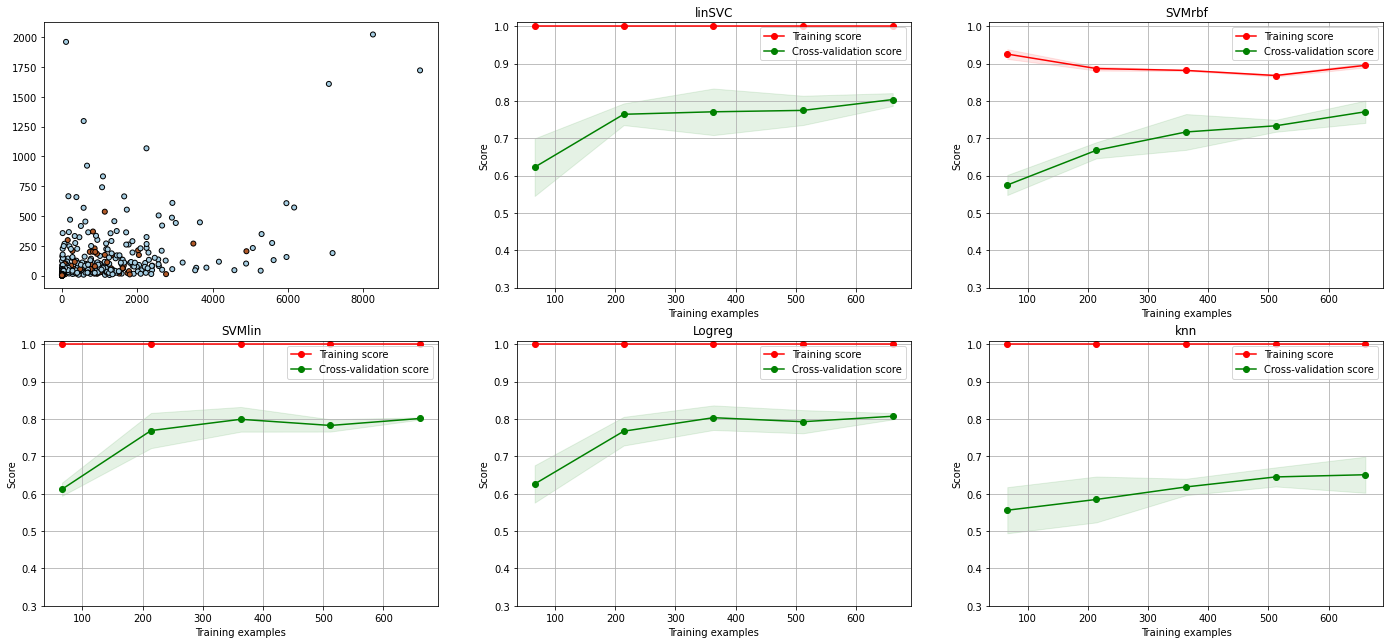

In [ ]:
# Learning Curve


clsfs = {'linSVC': LinearSVC(class_weight='balanced', dual=False, max_iter=10000), 
          'SVMrbf':SVC(kernel='rbf', class_weight='balanced'), 
          'SVMlin': SVC(kernel='linear', class_weight='balanced'), 
          'Logreg': LogisticRegression(class_weight='balanced', dual=False, max_iter=10000),
          'knn': KNeighborsClassifier(weights='distance')}
                  

num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(data_points[:, 0], data_points[:, 1], marker='o', c=data_labels, 
           s=25, edgecolor='k', cmap=plt.cm.Paired)

cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
num = 1
for key, clf in clsfs.items():
    title = str(key)
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, data_points, data_labels, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1


## PCA plot


<function matplotlib.pyplot.show>

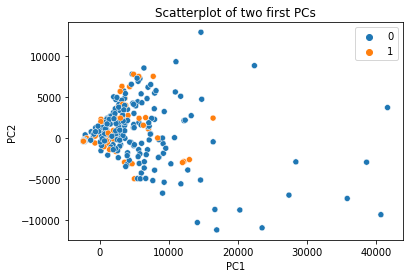

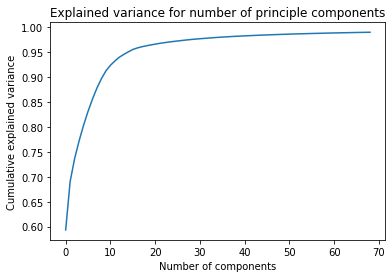

In [ ]:
pca = PCA(n_components=0.99)
pca = pca.fit(data_points)
x_trans = pca.transform(data_points)
explained_variance = pca.explained_variance_
y = data_labels

plt.figure(0)
sns.scatterplot(x=x_trans[:, 0], y=x_trans[:, 1], hue=y) # Scatterplot of two first PCs
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of two first PCs')

plt.figure(1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
ratio = pca.explained_variance_ratio_.cumsum()
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance for number of principle components')
plt.show


## Preprocessing and classifier validation

In [ ]:
# Splitting data  

cv_outer = StratifiedKFold(n_splits=5, shuffle=True)
cv_inner = StratifiedKFold(n_splits=3, shuffle=True)
outer_results = list()
all_scores = list()
models = list()

for train_ix, val_ix in cv_outer.split(x_train_val,y_train_val):
  # split data
  x_train, x_val = x_train_val[train_ix, :], x_train_val[val_ix, :]
  y_train, y_val = y_train_val[train_ix], y_train_val[val_ix]

  #Resampling
  resample = RandomUnderSampler(sampling_strategy='majority')
  x_resampled, y_resampled = resample.fit_resample(x_train, y_train)

  #Scaling
  scaler = RobustScaler()
  scaler.fit(x_resampled)
  x_train_scaled = scaler.transform(x_resampled)
  x_val_scaled = scaler.transform(x_val)

  #PCA
  pca = PCA(n_components=0.99)
  pca = pca.fit(x_train_scaled)
  x_train_trans = pca.transform(x_train_scaled)
  x_val_trans = pca.transform(x_val_scaled)
  print(f'Amount of training samples after resampling: {x_train_trans.shape[0]}')
  print(f'Amount of features from PCA: {x_train_trans.shape[1]}')
  model_params = {
                  'svm_rbf': 
                  {'model': SVC(kernel='rbf', class_weight='balanced'),
                    'params': {'C': np.arange(0.01,100,0.01),
                               'gamma': np.arange(0.01,100,0.01)
                               }
                  },
                   'svm_lin': 
                  {'model': SVC(kernel='linear', class_weight='balanced'),
                    'params': {'C': np.arange(0.01,100,0.01)
                               }
                   },
                  'linsvc': 
                  {'model': LinearSVC(class_weight='balanced', dual=False, max_iter=10000),
                   'params':{'C': np.arange(0.01,100,0.01)
                             }
                  },
                  'logreg':
                  {'model': LogisticRegression(class_weight='balanced', dual=False, max_iter=10000),
                   'params':{'C': np.arange(0.01,100,0.01)
                             }                      
                  },
                  'knn':
                  {'model': KNeighborsClassifier(weights='distance'),
                   'params':{
                        'n_neighbors': [5,10,15],
                        'leaf_size': np.arange(1,100,1)
                             }
                   }
                }

  for model_name, mp in model_params.items():
    search = RandomizedSearchCV(mp['model'], mp['params'], cv = cv_inner, scoring = 'roc_auc', return_train_score=True)
    result = search.fit(x_train_scaled, y_resampled)
    best_model = result.best_estimator_
    models.append(best_model)
    yhat = best_model.predict(x_val_scaled)
    auc_score_val = roc_auc_score(y_val, yhat)
    outer_results.append(auc_score_val)
    all_scores.append(result.best_score_)
    print(f' auc: {round(auc_score_val, 3)}, result.best_score_:{round(result.best_score_, 3)}, Model:{model_name}, best parameters:{result.best_params_}')
    

Amount of training samples after resampling: 186
Amount of features from PCA: 15
 auc: 0.5, result.best_score_:0.5, Model:svm_rbf, best parameters:{'gamma': 24.430000000000003, 'C': 29.200000000000003}
 auc: 0.578, result.best_score_:0.67, Model:svm_lin, best parameters:{'C': 37.97}
 auc: 0.608, result.best_score_:0.71, Model:linsvc, best parameters:{'C': 66.85000000000001}
 auc: 0.592, result.best_score_:0.629, Model:logreg, best parameters:{'C': 12.78}
 auc: 0.522, result.best_score_:0.589, Model:knn, best parameters:{'n_neighbors': 15, 'leaf_size': 46}
Amount of training samples after resampling: 188
Amount of features from PCA: 120
 auc: 0.5, result.best_score_:0.5, Model:svm_rbf, best parameters:{'gamma': 66.73, 'C': 29.040000000000003}
 auc: 0.683, result.best_score_:0.755, Model:svm_lin, best parameters:{'C': 11.31}
 auc: 0.691, result.best_score_:0.772, Model:linsvc, best parameters:{'C': 5.52}
 auc: 0.678, result.best_score_:0.718, Model:logreg, best parameters:{'C': 65.03}
 a

## Best classifier for test set

All calculated classifiers, ordered on AUC score:


,Auc score,Best score,Model
12,0.706821,0.615646,"LinearSVC(C=44.629999999999995, class_weight='..."
13,0.698843,0.680671,"LogisticRegression(C=62.68, class_weight='bala..."
21,0.692130,0.784599,"SVC(C=25.250000000000004, break_ties=False, ca..."
7,0.690666,0.771766,"LinearSVC(C=5.52, class_weight='balanced', dua..."
6,0.682688,0.755257,"SVC(C=11.31, break_ties=False, cache_size=200,..."
18,0.680495,0.736754,"LogisticRegression(C=75.73, class_weight='bala..."
16,0.680495,0.707596,"SVC(C=75.04, break_ties=False, cache_size=200,..."
17,0.679298,0.758075,"LinearSVC(C=94.89, class_weight='balanced', du..."
8,0.678101,0.717915,"LogisticRegression(C=65.03, class_weight='bala..."
11,0.675907,0.642842,"SVC(C=92.22000000000001, break_ties=False, cac..."


The best classifier is: LinearSVC(C=44.629999999999995, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=10000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)
Misclassified: 43 / 166
Auc score test data: 0.7343317392398692


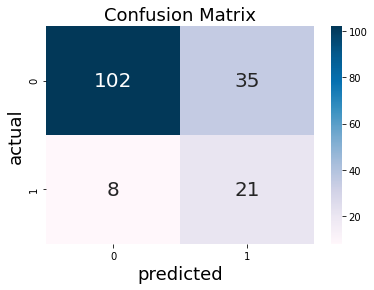

In [ ]:
models_df = pd.DataFrame(models)
outer_results_df = pd.DataFrame(outer_results)
all_scores_df = pd.DataFrame(all_scores)
results = pd.concat([outer_results_df, all_scores_df, models_df], axis=1)
results.columns = [ 'Auc score', 'Best score', 'Model']
results_sorted = results.sort_values(by=['Auc score'], ascending=False)
print('All calculated classifiers, ordered on AUC score:')
display(results_sorted)

best_classifier = results_sorted['Model'].iloc[0]
print(f'The best classifier is: {best_classifier}')

#Resampling
resample = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = resample.fit_resample(x_train_val, y_train_val)

#Scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_resampled)
x_train_scaled = scaler.transform(X_resampled)
x_test_scaled = scaler.transform(x_test)

#PCA
pca = PCA(n_components=0.99)
pca = pca.fit(x_train_scaled)
x_train_trans = pca.transform(x_train_scaled)
x_test_trans = pca.transform(x_test_scaled)

# Evaluation classifier
clf = best_classifier.fit(x_train_trans, y_resampled)
y_pred = clf.predict(x_test_trans)
y_score = clf.decision_function(x_test_trans)
accuracy = balanced_accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print('Misclassified: %d / %d' % ((y_test != y_pred).sum(), x_test_trans.shape[0]))
evaluation(y_test, y_pred)

print(f'Auc score test data: {auc_score}')


## ROC curve

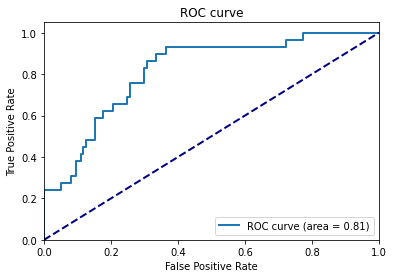

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

roc_plotter(fpr, tpr, roc_auc)